In [2]:
import pandas as pd
import os
import torch
from PIL import Image
from transformers import CLIPModel
from transformers import CLIPProcessor
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
import cv2
import webcolors
import faiss
from torchvision import models, transforms
import time

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [4]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

#whereever you loaded your vit_h file
sam_checkpoint ="/Users/meagankenney/IMA Bootcamp/Ebay/sam_vit_h_4b8939.pth"
model_type = "vit_h"


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
#sam.to(device=device)

predictor = SamPredictor(sam)

In [5]:
import cv2

def get_clicked_point(image_path):
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Create a copy of the image for display
    display_image = image.copy()

    # Flag to indicate if a point has been captured
    point_captured = False

    # Variables to store the clicked coordinates
    clicked_x = None
    clicked_y = None

    def click_callback(event, x, y, flags, param):
        nonlocal point_captured, clicked_x, clicked_y

        # Check if the left mouse button is pressed
        if event == cv2.EVENT_LBUTTONDOWN and not point_captured:
            # Store the clicked coordinates
            clicked_x = x
            clicked_y = y

            # Print the coordinates
            print(f"Clicked coordinates: x={clicked_x}, y={clicked_y}")

            # Draw a circle at the clicked point
            cv2.circle(display_image, (clicked_x, clicked_y), 5, (0, 0, 255), -1)
            cv2.imshow("Image", display_image)

            # Set the flag to indicate a point has been captured
            point_captured = True

    # Create a window and set the callback function
    cv2.namedWindow("Image")
    cv2.setMouseCallback("Image", click_callback)

    # Display the image
    cv2.imshow("Image", display_image)

    # Wait for a point to be captured or 'Esc' key is pressed
    while not point_captured:
        key = cv2.waitKey(1) & 0xFF
        if key == 27:  # 'Esc' key
            break

    # Close all windows
    cv2.destroyAllWindows()

    # Return the clicked coordinates if a point was captured, otherwise return None
    if point_captured:
        return [(clicked_x, clicked_y)]
    else:
        return None


In [6]:
#image_path = '/Users/meagankenney/IMA Bootcamp/Ebay/model_Test.png'
image_path = '/Users/meagankenney/IMA Bootcamp/Ebay/modelWithShirt.jpeg'
#image_path = '/Users/meagankenney/IMA Bootcamp/Ebay/backpackTest.png'
#image_path = '/Users/meagankenney/IMA Bootcamp/Ebay/patternshirt.jpeg'
#image_path = '/Users/meagankenney/IMA Bootcamp/Ebay/stripeshirt.jpeg'

clicked_point = get_clicked_point(image_path)
print("Clicked point:", clicked_point)

Clicked coordinates: x=145, y=154
Clicked point: [(145, 154)]


In [7]:
#put a path to your picture in parentheses below
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

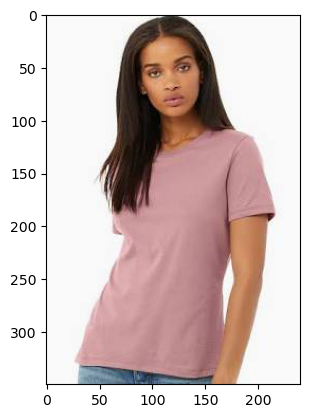

In [8]:
plt.imshow(image)

In [9]:
predictor.set_image(image)

In [10]:
#pick the two numbers in brackets below to indicate on what you want segment anything to create the mask
input_point = np.array(clicked_point)
input_label = np.array([1])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

int_mask = masks.astype(int)

In [11]:
width = image.shape[0]
height = image.shape[1]

In [12]:
pattern = Image.open('/Users/meagankenney/IMA Bootcamp/Ebay/leopard_print.jpeg')
print(f"Original size : {image.size}") # 5464x3640

pattern_resized = pattern.resize((height, width))
pattern_resized.save('/Users/meagankenney/IMA Bootcamp/Ebay/leopard_print.jpeg')

Original size : 252000


In [13]:
#put a path to your picture in parentheses below
pattern = cv2.imread('/Users/meagankenney/IMA Bootcamp/Ebay/leopard_print.jpeg')
pattern = cv2.cvtColor(pattern, cv2.COLOR_BGR2RGB)

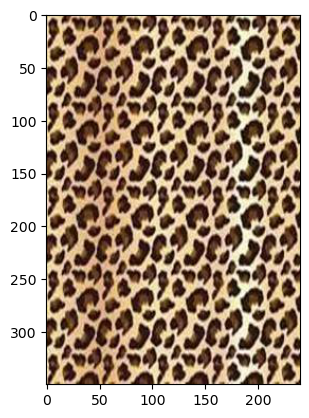

In [14]:
plt.imshow(pattern)

In [15]:
# Extracting pixel map:
# Extracting the width and height 
# of the image:
width = image.shape[0]
height = image.shape[1]
for i in range(width):
    for j in range(height):
        # getting the current RGB value of pixel (i,j).
        if int_mask[0][i][j]==0:
            image[i][j]=(255,255,255)
        
        

In [16]:
# Extracting pixel map:
# Extracting the width and height 
# of the image:
colList=[]
width = image.shape[0]
height = image.shape[1]
for i in range(width):
    for j in range(height):
        # getting the current RGB value of pixel (i,j).
        if int_mask[0][i][j]==1:
            colList.append(image[i][j])
        
        

In [17]:
colListPattern=[]
width = image.shape[0]
height = image.shape[1]
for i in range(width):
    for j in range(height):
        # getting the current RGB value of pixel (i,j).
        if int_mask[0][i][j]==1:
            colListPattern.append(pattern[i][j])

In [18]:
def scale_list(values, min_val, max_val):
    # Convert the list to a NumPy array
    arr = np.array(values)

    # Find the minimum and maximum values in the array
    arr_min = np.min(arr)
    arr_max = np.max(arr)

    # Scale the values to be between min_val and max_val
    scaled_arr = (arr - arr_min) * (max_val - min_val) / (arr_max - arr_min) + min_val

    # Convert the scaled array back to a list
    scaled_list = scaled_arr.tolist()

    return scaled_list

In [19]:
def patternChange(pattern, pic):
    #Get dimensions of image
    width = pic.shape[0]
    height = pic.shape[1]
    
    #Go through all pixels in the picture and set them to their new color
    n=0
    for i in range(width):
        for j in range(height):
            # Is this picture on the segment we're recoloring?
            if int_mask[0][i][j]==1:
                pic[i][j][0]=pattern[i][j][0]
                pic[i][j][1]=pattern[i][j][1]
                pic[i][j][2] = pattern[i][j][2]
                
                 
    return image
    

In [20]:
def AvgColor(image):  
    colList=[]
    width = image.shape[0]
    height = image.shape[1]
    for i in range(width):
        for j in range(height):
            # getting the current RGB value of pixel (i,j).
            if int_mask[0][i][j]==1:
                colList.append(image[i][j])
    L=len(colList)
    m1=0
    m2=0
    m3=0
    for i in colList:
        m1+=i[0]
        m2+=i[1]
        m3+=i[2]
    return [(m1/L, m2/L, m3/L)]

In [21]:
width = image.shape[0]
height = image.shape[1]
newR=[]
newG=[]
newB=[]
c = 0
#Go through all pixels in the picture and set them to their new color

for i in range(width):
    for j in range(height):
            if int_mask[0][i][j]==1:
                c+=1

In [22]:
#patternChange(pattern,image)

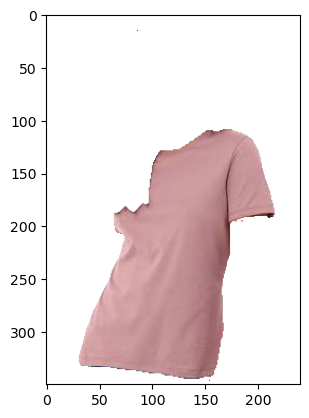

In [23]:
plt.imshow(image)

In [25]:
#current prefereable
def pattern4(col2, pic):
    #Get dimensions of image
    width = pic.shape[0]
    height = pic.shape[1]
    
    #Fix a base color
    startCol = AvgColor(pic)
    
    dif = []
    
    
    #How different is this base color from target color?
    for i in range(width):
        for j in range(height):
            if int_mask[0][i][j]==1:
                dif1 = startCol[0][0] - pattern[i][j][0]
                dif2 = startCol[0][1] - pattern[i][j][1]
                dif3 = startCol[0][2] - pattern[i][j][2]
                dif.append((dif1,dif2,dif3))
                
    #Make blank list for new color values
    newColR=[]
    newColG=[]
    newColB=[]
    
    #Make lists of the shifted colors from old to new RGB values
    c= 0
    for i in range(width):
        for j in range(height):
            if int_mask[0][i][j]==1:
                newColR.append(pic[i][j][0]-dif[c][0])
                newColG.append(pic[i][j][1]-dif[c][1])
                newColB.append(pic[i][j][2]-dif[c][2])
                c+=1
                
    #Rescale each color list to make sure it's in appropriate RGB value range
    minR = max(min(newColR), 0)
    maxR = min(max(newColR), 255)
    minG = max(min(newColG), 0)
    maxG = min(max(newColG), 255)
    minB = max(min(newColB), 0)
    maxB = min(max(newColB), 255)
    fixedColR = scale_list(newColR, minR,maxR)
    fixedColG = scale_list(newColG, minG,maxG)
    fixedColB =scale_list(newColB, minB,maxB)
    
    
    #Go through all pixels in the picture and set them to their new color
    n=0
    for i in range(width):
        for j in range(height):
            # Is this picture on the segment we're recoloring?
            if int_mask[0][i][j]==1:
                pic[i][j][0]=fixedColR[n]
                pic[i][j][1]=fixedColG[n]
                pic[i][j][2] = fixedColB[n]
                n+=1
                
    return image

In [113]:
def pattern5(col2, pic):
    #Get dimensions of image
    width = pic.shape[0]
    height = pic.shape[1]
    
    #Fix a base color
    startCol = AvgColor(pic)
    
    dif = []
    
    
    #How different is this base color from target color?
    for i in range(width):
        for j in range(height):
            if int_mask[0][i][j]==1:
                dif1 = startCol[0][0] - pattern[i][j][0]
                dif2 = startCol[0][1] - pattern[i][j][1]
                dif3 = startCol[0][2] - pattern[i][j][2]
                dif.append((dif1,dif2,dif3))
                
    #Make blank list for new color values
    newColR=[]
    newColG=[]
    newColB=[]
    
    #Make lists of the shifted colors from old to new RGB values
    c= 0
    for i in range(width):
        for j in range(height):
            if int_mask[0][i][j]==1:
                newColR.append(pic[i][j][0]-dif[c][0]+30)
                newColG.append(pic[i][j][1]-dif[c][1])
                newColB.append(pic[i][j][2]-dif[c][2]-30)
                c+=1
                
    #Rescale each color list to make sure it's in appropriate RGB value range
    minR = max(min(newColR), 0)
    maxR = min(max(newColR), 255)
    minG = max(min(newColG), 0)
    maxG = min(max(newColG), 255)
    minB = max(min(newColB), 0)
    maxB = min(max(newColB), 255)
    fixedColR = scale_list(newColR, minR,maxR)
    fixedColG = scale_list(newColG, minG,maxG)
    fixedColB =scale_list(newColB, minB,maxB)
    
    
    #Go through all pixels in the picture and set them to their new color
    n=0
    for i in range(width):
        for j in range(height):
            # Is this picture on the segment we're recoloring?
            if int_mask[0][i][j]==1:
                pic[i][j][0]=fixedColR[n]
                pic[i][j][1]=fixedColG[n]
                pic[i][j][2] = fixedColB[n]
                n+=1
                
    return image

In [96]:
AvgColor(image)[0][0]

156.69279477699993

In [97]:
def pattern6(col2, pic):
    #Get dimensions of image
    width = pic.shape[0]
    height = pic.shape[1]
    
    #Fix a base color
    startCol = AvgColor(pic)
    
    dif = []
    
    
    #How different is this base color from target color?
    for i in range(width):
        for j in range(height):
            if int_mask[0][i][j]==1:
                dif1 = startCol[0][0] - pic[i][j][0]
                dif2 = startCol[0][1] - pic[i][j][1]
                dif3 = startCol[0][2] - pic[i][j][2]
                dif.append((dif1,dif2,dif3))
                
    #Make blank list for new color values
    newColR=[]
    newColG=[]
    newColB=[]
    
    #Make lists of the shifted colors from old to new RGB values
    c= 0
    for i in range(width):
        for j in range(height):
            if int_mask[0][i][j]==1:
                newColR.append(pattern[i][j][0]-dif[c][0])
                newColG.append(pattern[i][j][1]-dif[c][1])
                newColB.append(pattern[i][j][2]-dif[c][2])
                c+=1
                
    #Rescale each color list to make sure it's in appropriate RGB value range
    minR = max(min(newColR), 0)
    maxR = min(max(newColR), 255)
    minG = max(min(newColG), 0)
    maxG = min(max(newColG), 255)
    minB = max(min(newColB), 0)
    maxB = min(max(newColB), 255)
    fixedColR = scale_list(newColR, minR,maxR)
    fixedColG = scale_list(newColG, minG,maxG)
    fixedColB =scale_list(newColB, minB,maxB)
    
    
    #Go through all pixels in the picture and set them to their new color
    n=0
    for i in range(width):
        for j in range(height):
            # Is this picture on the segment we're recoloring?
            if int_mask[0][i][j]==1:
                pic[i][j][0]=fixedColR[n]
                pic[i][j][1]=fixedColG[n]
                pic[i][j][2] = fixedColB[n]
                n+=1
                
    return image

In [98]:
pattern4(pattern,image)

array([[[250, 250, 250],
        [250, 250, 250],
        [250, 250, 250],
        ...,
        [250, 250, 250],
        [250, 250, 250],
        [250, 250, 250]],

       [[250, 250, 250],
        [250, 250, 250],
        [250, 250, 250],
        ...,
        [250, 250, 250],
        [250, 250, 250],
        [250, 250, 250]],

       [[250, 250, 250],
        [250, 250, 250],
        [250, 250, 250],
        ...,
        [250, 250, 250],
        [250, 250, 250],
        [250, 250, 250]],

       ...,

       [[250, 250, 250],
        [250, 250, 250],
        [250, 250, 250],
        ...,
        [250, 250, 250],
        [250, 250, 250],
        [250, 250, 250]],

       [[250, 250, 250],
        [250, 250, 250],
        [250, 250, 250],
        ...,
        [250, 250, 250],
        [250, 250, 250],
        [250, 250, 250]],

       [[250, 250, 250],
        [250, 250, 250],
        [250, 250, 250],
        ...,
        [250, 250, 250],
        [250, 250, 250],
        [250, 250, 250]]

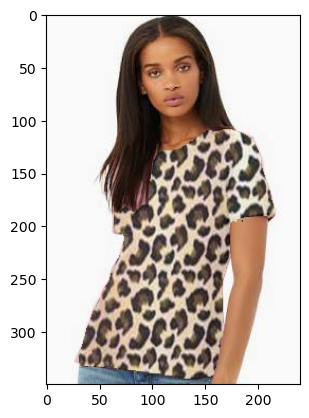

In [99]:
plt.imshow(image)

In [129]:
#put a path to your picture in parentheses below
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pattern_path = '/Users/meagankenney/IMA Bootcamp/Ebay/jean.jpeg'
pattern = Image.open(pattern_path)
print(f"Original size : {image.size}") # 5464x3640

pattern_resized = pattern.resize((height, width))
pattern_resized.save(pattern_path)
#put a path to your picture in parentheses below
pattern = cv2.imread(pattern_path)
pattern = cv2.cvtColor(pattern, cv2.COLOR_BGR2RGB)

Original size : 252000


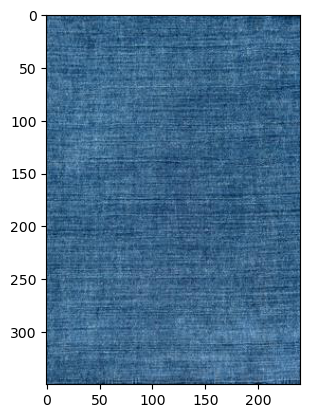

In [130]:
plt.imshow(pattern)

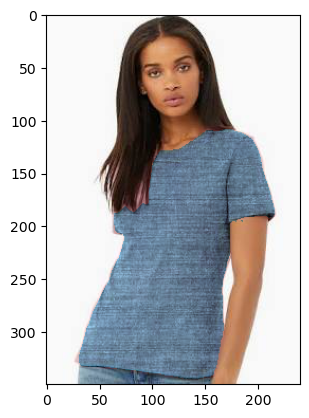

In [131]:
plt.imshow(pattern4(pattern,image))

Original size : 252000


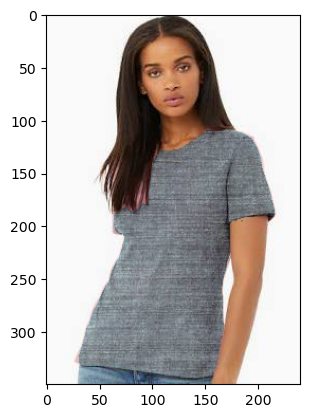

In [128]:
#put a path to your picture in parentheses below
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pattern_path = '/Users/meagankenney/IMA Bootcamp/Ebay/jean.jpeg'
pattern = Image.open(pattern_path)
print(f"Original size : {image.size}") # 5464x3640

pattern_resized = pattern.resize((height, width))
pattern_resized.save(pattern_path)
#put a path to your picture in parentheses below
pattern = cv2.imread(pattern_path)
pattern = cv2.cvtColor(pattern, cv2.COLOR_BGR2RGB)
plt.imshow(pattern5(pattern,image))

In [77]:
#look at other color space besides RGB

In [114]:
pattern5(pattern,image)

array([[[250, 250, 250],
        [250, 250, 250],
        [250, 250, 250],
        ...,
        [250, 250, 250],
        [250, 250, 250],
        [250, 250, 250]],

       [[250, 250, 250],
        [250, 250, 250],
        [250, 250, 250],
        ...,
        [250, 250, 250],
        [250, 250, 250],
        [250, 250, 250]],

       [[250, 250, 250],
        [250, 250, 250],
        [250, 250, 250],
        ...,
        [250, 250, 250],
        [250, 250, 250],
        [250, 250, 250]],

       ...,

       [[250, 250, 250],
        [250, 250, 250],
        [250, 250, 250],
        ...,
        [250, 250, 250],
        [250, 250, 250],
        [250, 250, 250]],

       [[250, 250, 250],
        [250, 250, 250],
        [250, 250, 250],
        ...,
        [250, 250, 250],
        [250, 250, 250],
        [250, 250, 250]],

       [[250, 250, 250],
        [250, 250, 250],
        [250, 250, 250],
        ...,
        [250, 250, 250],
        [250, 250, 250],
        [250, 250, 250]]

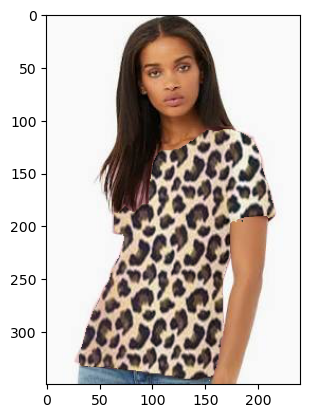

In [115]:
plt.imshow(image)

In [116]:
def get_rgb_from_color_name(color_name):
    try:
        rgb = webcolors.name_to_rgb(color_name)
        return tuple(rgb)
    except ValueError:
        return None

In [117]:
def colorChange3(col2, pic):
    #Get dimensions of image
    width = pic.shape[0]
    height = pic.shape[1]
    
    #Fix a base color
    startCol = AvgColor(pic)
    
    #How different is this base color from target color?
    dif1 = startCol[0][0] - col2[0]
    dif2 = startCol[0][1] - col2[1]
    dif3 = startCol[0][2] - col2[2]
    
    #Make blank list for new color values
    newColR=[]
    newColG=[]
    newColB=[]
    
    #Make lists of the shifted colors from old to new RGB values
    for i in range(width):
        for j in range(height):
            if int_mask[0][i][j]==1:
                newColR.append(pic[i][j][0]-dif1)
                newColG.append(pic[i][j][1]-dif2)
                newColB.append(pic[i][j][2]-dif3)
                
    #Rescale each color list to make sure it's in appropriate RGB value range
    minR = max(min(newColR), 0)
    maxR = min(max(newColR), 255)
    minG = max(min(newColG), 0)
    maxG = min(max(newColG), 255)
    minB = max(min(newColB), 0)
    maxB = min(max(newColB), 255)
    fixedColR = scale_list(newColR, minR,maxR)
    fixedColG = scale_list(newColG, minG,maxG)
    fixedColB =scale_list(newColB, minB,maxB)
    
    
    #Go through all pixels in the picture and set them to their new color
    n=0
    for i in range(width):
        for j in range(height):
            # Is this picture on the segment we're recoloring?
            if int_mask[0][i][j]==1:
                pic[i][j][0]=fixedColR[n]
                pic[i][j][1]=fixedColG[n]
                pic[i][j][2] = fixedColB[n]
                n+=1
                
    return image

Original size : 252000


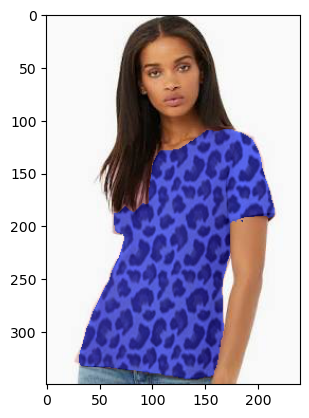

In [132]:
#put a path to your picture in parentheses below
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pattern_path = '/Users/meagankenney/IMA Bootcamp/Ebay/leopard_print.jpeg'
pattern = Image.open(pattern_path)
print(f"Original size : {image.size}") # 5464x3640

pattern_resized = pattern.resize((height, width))
pattern_resized.save(pattern_path)
#put a path to your picture in parentheses below
pattern = cv2.imread(pattern_path)
pattern = cv2.cvtColor(pattern, cv2.COLOR_BGR2RGB)
pattern4(pattern,image)
color_name = "mediumblue"
color_name =  color_name.replace(" ", "")
newColor = get_rgb_from_color_name(color_name)
image = colorChange3(newColor, image)
plt.imshow(image)